<a href="https://colab.research.google.com/github/yasinsoylu1997/TEZZ2/blob/main/vgg19_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix
import keras
import keras.utils
from keras import utils as np_utils
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
#!pip install visualkeras
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import os
!pip install visualkeras
!pip install catboost

     |████████████████████████████████| 992 kB 5.3 MB/s 
     |████████████████████████████████| 76.6 MB 38 kB/s 


In [3]:
labels = ['Lung_Opacity','COVID','Normal','Viral Pneumonia']

In [4]:
X = []
y = []
image_size = 32
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/tezz3/COVID-19_Radiography_Dataset_masked',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X.append(img)
        y.append(i)

        
X = np.array(X)
y = np.array(y)

100%|██████████| 1345/1345 [00:20<00:00, 66.83it/s] 


In [5]:
from imblearn.over_sampling import RandomOverSampler
reshaped_X = X.reshape(X.shape[0],-1)

#oversampling
oversample = RandomOverSampler()
oversampled_X, oversampled_y  = oversample.fit_resample(reshaped_X , y)

# reshaping X back to the first dims
new_X = oversampled_X.reshape(-1,32,32,3)
oversampled_y

array(['Lung_Opacity', 'Lung_Opacity', 'Lung_Opacity', ...,
       'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia'],
      dtype='<U15')

In [6]:
train_images, test_images,train_labels, test_labels = train_test_split(new_X , oversampled_y , test_size=0.25, random_state=42,shuffle=True)

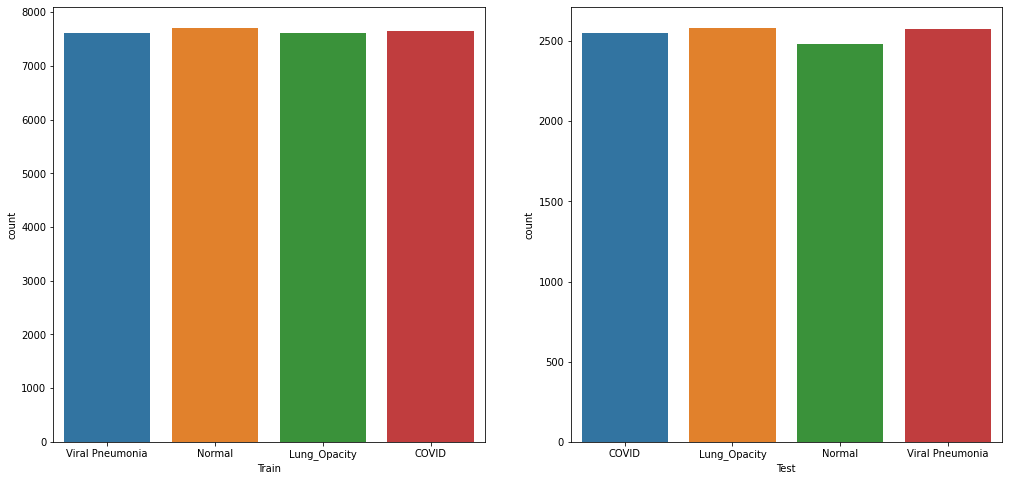

In [7]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

In [8]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [10]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [11]:
#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [12]:
y_test_one_hot

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [13]:
#Load model wothout classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

In [14]:
#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_model= features #This is our X input for model

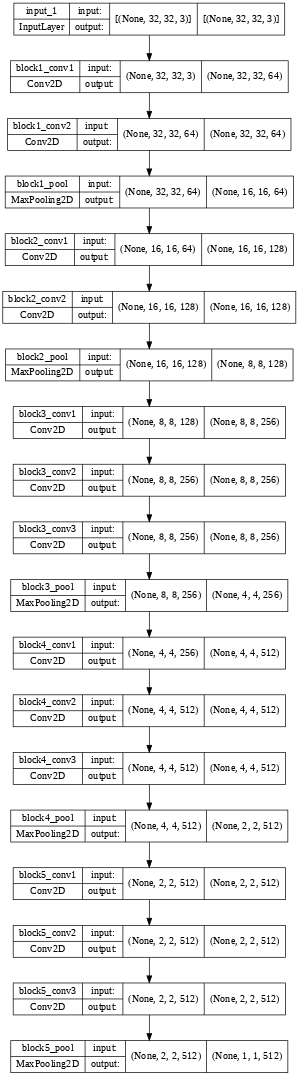

In [15]:
from keras.utils.vis_utils import plot_model

plot_model(VGG_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=50)

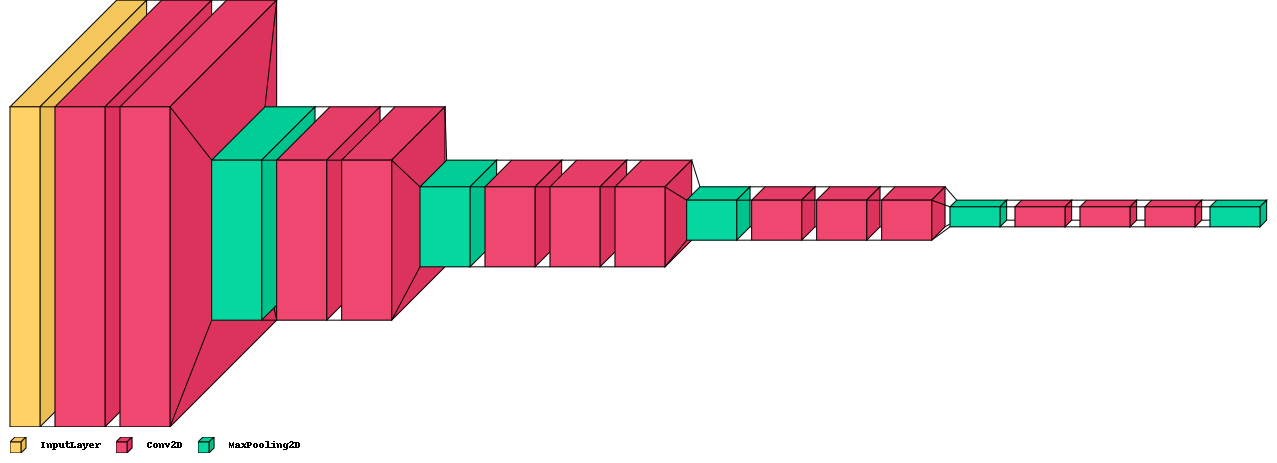

<Figure size 144x144 with 0 Axes>

In [16]:
import visualkeras
from PIL import ImageFont
plt.figure(figsize=(2, 2))
visualkeras.layered_view(VGG_model, legend=True,spacing=15,scale_xy = 10 , scale_z = 10, max_z = 50) 

In [17]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X_for_model, y_train)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('Accuracy', Accuracy)



    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    return mae, mse, rmse, r2_square, Accuracy

# knn

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_model = knn.fit(X_for_model, y_train)
knn_model

KNeighborsClassifier()

In [19]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = knn_model.predict(X_test_features)

In [20]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.2889521193092622
MSE: 0.43239795918367346
RMSE: 0.6575697371257846
R2 Square 0.6558104705236476
Accuracy 0.7810047095761381
__________________________________


In [21]:
results_df = pd.DataFrame(data=[["KNeighborsClassifier", *evaluate(y_test, prediction) ]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19'])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.288952,0.432398,0.65757,0.65581,0.781005


In [22]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.69      0.78      0.73      2550
           1       0.74      0.66      0.70      2583
           2       0.74      0.69      0.72      2481
           3       0.95      0.99      0.97      2578

    accuracy                           0.78     10192
   macro avg       0.78      0.78      0.78     10192
weighted avg       0.78      0.78      0.78     10192



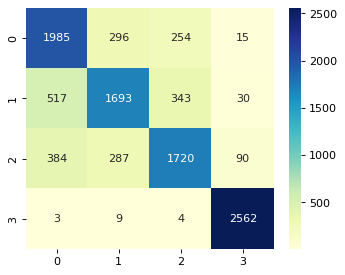

In [23]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SVC

In [24]:
from sklearn.svm import SVC
svm_model = SVC(kernel = "linear")
svm_model = svm_model.fit(X_for_model, y_train)
svm_model

SVC(kernel='linear')

In [25]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = svm_model.predict(X_test_features)

In [26]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.3017072213500785
MSE: 0.4632064364207221
RMSE: 0.6805927096441176
R2 Square 0.6312868689226548
Accuracy 0.7773744113029827
__________________________________


In [27]:
results_df_2 = pd.DataFrame(data=[["SVC", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.288952,0.432398,0.657570,0.655810,0.781005
1,SVC,0.301707,0.463206,0.680593,0.631287,0.777374


In [28]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.69      0.66      0.68      2550
           1       0.74      0.72      0.73      2583
           2       0.71      0.75      0.73      2481
           3       0.96      0.97      0.97      2578

    accuracy                           0.78     10192
   macro avg       0.78      0.78      0.78     10192
weighted avg       0.78      0.78      0.78     10192



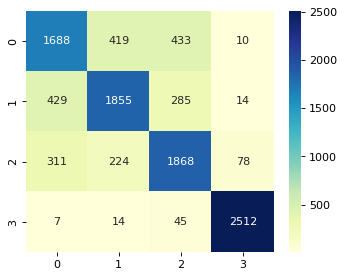

In [29]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# RBF SVC

In [30]:
from sklearn.svm import SVC

svc_model = SVC(kernel = "rbf").fit(X_for_model, y_train)
svc_model = svc_model.fit(X_for_model, y_train)
svc_model

SVC()

In [31]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = svc_model.predict(X_test_features)

In [32]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.36813186813186816
MSE: 0.5875196232339089
RMSE: 0.7664982865172687
R2 Square 0.5323333554562291
Accuracy 0.7351844583987441
__________________________________


In [33]:
results_df_2 = pd.DataFrame(data=[["RBF SVC", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.288952,0.432398,0.657570,0.655810,0.781005
1,SVC,0.301707,0.463206,0.680593,0.631287,0.777374
2,RBF SVC,0.368132,0.587520,0.766498,0.532333,0.735184


In [34]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.65      0.59      0.61      2550
           1       0.69      0.69      0.69      2583
           2       0.66      0.72      0.69      2481
           3       0.93      0.94      0.94      2578

    accuracy                           0.74     10192
   macro avg       0.73      0.73      0.73     10192
weighted avg       0.73      0.74      0.73     10192



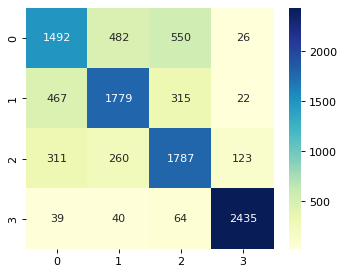

In [35]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# DecisionTreeClassifier

In [36]:
from sklearn.tree import DecisionTreeClassifier
cart_model = DecisionTreeClassifier()
cart_model = cart_model.fit(X_for_model, y_train)
cart_model

DecisionTreeClassifier()

In [37]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = cart_model.predict(X_test_features)

In [38]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.19142464678178964
MSE: 0.2828689167974882
RMSE: 0.5318542251383251
R2 Square 0.7748358489947075
Accuracy 0.8540031397174255
__________________________________


In [39]:
results_df_2 = pd.DataFrame(data=[["DecisionTreeClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.288952,0.432398,0.657570,0.655810,0.781005
1,SVC,0.301707,0.463206,0.680593,0.631287,0.777374
2,RBF SVC,0.368132,0.587520,0.766498,0.532333,0.735184
3,DecisionTreeClassifier,0.191425,0.282869,0.531854,0.774836,0.854003


In [40]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      2550
           1       0.81      0.81      0.81      2583
           2       0.81      0.69      0.75      2481
           3       0.97      1.00      0.98      2578

    accuracy                           0.85     10192
   macro avg       0.85      0.85      0.85     10192
weighted avg       0.85      0.85      0.85     10192



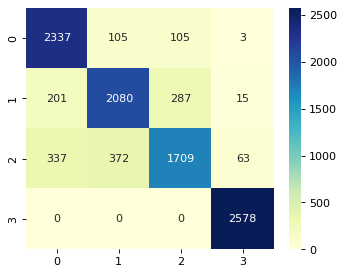

In [41]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# Lojistik regresyon

In [42]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model = lr_model.fit(X_for_model, y_train)
lr_model

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [43]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = lr_model.predict(X_test_features)

In [44]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.3764717425431711
MSE: 0.6009615384615384
RMSE: 0.7752170911825529
R2 Square 0.5216335674965602
Accuracy 0.728414442700157
__________________________________


In [45]:
results_df_2 = pd.DataFrame(data=[["LogisticRegression", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.288952,0.432398,0.657570,0.655810,0.781005
1,SVC,0.301707,0.463206,0.680593,0.631287,0.777374
2,RBF SVC,0.368132,0.587520,0.766498,0.532333,0.735184
3,DecisionTreeClassifier,0.191425,0.282869,0.531854,0.774836,0.854003
4,LogisticRegression,0.376472,0.600962,0.775217,0.521634,0.728414


In [46]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.64      0.58      0.61      2550
           1       0.68      0.69      0.69      2583
           2       0.66      0.70      0.68      2481
           3       0.92      0.94      0.93      2578

    accuracy                           0.73     10192
   macro avg       0.73      0.73      0.73     10192
weighted avg       0.73      0.73      0.73     10192



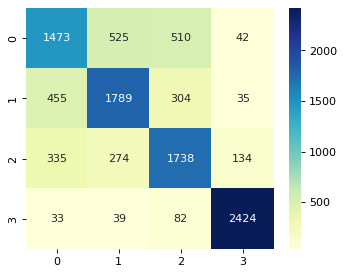

In [47]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SGDClassifier

In [48]:
from sklearn.linear_model import SGDClassifier

SGD_model = SGDClassifier()
SGD_model = SGD_model.fit(X_for_model, y_train)
SGD_model

SGDClassifier()

In [49]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = SGD_model.predict(X_test_features)

In [50]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.35066718995290425
MSE: 0.5688775510204082
RMSE: 0.7542397172122456
R2 Square 0.5471724774440909
Accuracy 0.7531397174254317
__________________________________


In [51]:
results_df_2 = pd.DataFrame(data=[["SGDClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.288952,0.432398,0.657570,0.655810,0.781005
1,SVC,0.301707,0.463206,0.680593,0.631287,0.777374
2,RBF SVC,0.368132,0.587520,0.766498,0.532333,0.735184
3,DecisionTreeClassifier,0.191425,0.282869,0.531854,0.774836,0.854003
4,LogisticRegression,0.376472,0.600962,0.775217,0.521634,0.728414
5,SGDClassifier,0.350667,0.568878,0.754240,0.547172,0.753140


In [52]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.68      0.63      0.65      2550
           1       0.79      0.62      0.69      2583
           2       0.63      0.80      0.71      2481
           3       0.93      0.97      0.95      2578

    accuracy                           0.75     10192
   macro avg       0.76      0.75      0.75     10192
weighted avg       0.76      0.75      0.75     10192



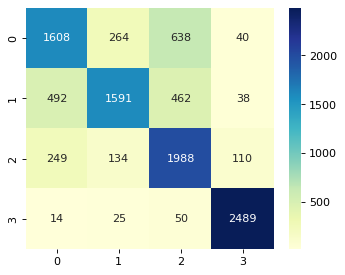

In [53]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# GradientBoostingClassifier

In [54]:
from sklearn.ensemble import GradientBoostingClassifier

GBC_model = GradientBoostingClassifier()
GBC_model = GBC_model.fit(X_for_model, y_train)
GBC_model

GradientBoostingClassifier()

In [55]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = GBC_model.predict(X_test_features)

In [56]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.31475667189952905
MSE: 0.49038461538461536
RMSE: 0.7002746713858894
R2 Square 0.6096529910771932
Accuracy 0.7699175824175825
__________________________________


In [57]:
results_df_2 = pd.DataFrame(data=[["GradientBoostingClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.288952,0.432398,0.657570,0.655810,0.781005
1,SVC,0.301707,0.463206,0.680593,0.631287,0.777374
2,RBF SVC,0.368132,0.587520,0.766498,0.532333,0.735184
3,DecisionTreeClassifier,0.191425,0.282869,0.531854,0.774836,0.854003
4,LogisticRegression,0.376472,0.600962,0.775217,0.521634,0.728414
5,SGDClassifier,0.350667,0.568878,0.754240,0.547172,0.753140
6,GradientBoostingClassifier,0.314757,0.490385,0.700275,0.609653,0.769918


In [58]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.70      0.65      0.67      2550
           1       0.73      0.72      0.72      2583
           2       0.70      0.73      0.71      2481
           3       0.95      0.98      0.96      2578

    accuracy                           0.77     10192
   macro avg       0.77      0.77      0.77     10192
weighted avg       0.77      0.77      0.77     10192



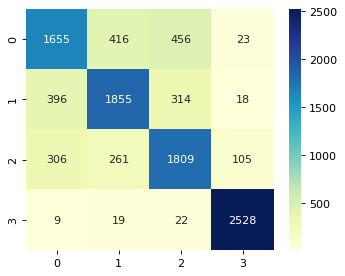

In [59]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# LGBMClassifier

In [60]:
from lightgbm import LGBMClassifier

LGBM_model = LGBMClassifier()
LGBM_model = LGBM_model.fit(X_for_model, y_train)
LGBM_model

LGBMClassifier()

In [61]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = LGBM_model.predict(X_test_features)

In [62]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.20839874411302983
MSE: 0.309458398744113
RMSE: 0.5562898513761626
R2 Square 0.753670575001494
Accuracy 0.8417386185243328
__________________________________


In [63]:
results_df_2 = pd.DataFrame(data=[["LGBMClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.288952,0.432398,0.657570,0.655810,0.781005
1,SVC,0.301707,0.463206,0.680593,0.631287,0.777374
2,RBF SVC,0.368132,0.587520,0.766498,0.532333,0.735184
3,DecisionTreeClassifier,0.191425,0.282869,0.531854,0.774836,0.854003
4,LogisticRegression,0.376472,0.600962,0.775217,0.521634,0.728414
5,SGDClassifier,0.350667,0.568878,0.754240,0.547172,0.753140
6,GradientBoostingClassifier,0.314757,0.490385,0.700275,0.609653,0.769918
7,LGBMClassifier,0.208399,0.309458,0.556290,0.753671,0.841739


In [64]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.80      0.79      0.80      2550
           1       0.80      0.79      0.80      2583
           2       0.79      0.78      0.78      2481
           3       0.97      1.00      0.98      2578

    accuracy                           0.84     10192
   macro avg       0.84      0.84      0.84     10192
weighted avg       0.84      0.84      0.84     10192



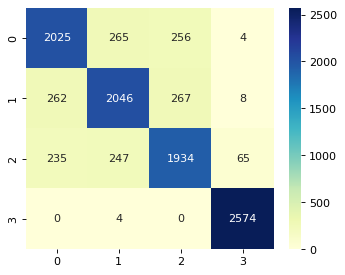

In [65]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# XGBClassifier

In [66]:
from xgboost.sklearn import XGBClassifier

XGBC_model = XGBClassifier()
XGBC_model = XGBC_model.fit(X_for_model, y_train)
XGBC_model

XGBClassifier(objective='multi:softprob')

In [67]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = XGBC_model.predict(X_test_features)

In [68]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.34664442700156983
MSE: 0.5505298273155416
RMSE: 0.7419769722272663
R2 Square 0.5617772975058285
Accuracy 0.7500981161695447
__________________________________


In [69]:
results_df_2 = pd.DataFrame(data=[["XGBClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.288952,0.432398,0.657570,0.655810,0.781005
1,SVC,0.301707,0.463206,0.680593,0.631287,0.777374
2,RBF SVC,0.368132,0.587520,0.766498,0.532333,0.735184
3,DecisionTreeClassifier,0.191425,0.282869,0.531854,0.774836,0.854003
4,LogisticRegression,0.376472,0.600962,0.775217,0.521634,0.728414
5,SGDClassifier,0.350667,0.568878,0.754240,0.547172,0.753140
6,GradientBoostingClassifier,0.314757,0.490385,0.700275,0.609653,0.769918
7,LGBMClassifier,0.208399,0.309458,0.556290,0.753671,0.841739
8,XGBClassifier,0.346644,0.550530,0.741977,0.561777,0.750098


In [70]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.68      0.61      0.65      2550
           1       0.71      0.70      0.70      2583
           2       0.66      0.72      0.69      2481
           3       0.94      0.97      0.95      2578

    accuracy                           0.75     10192
   macro avg       0.75      0.75      0.75     10192
weighted avg       0.75      0.75      0.75     10192



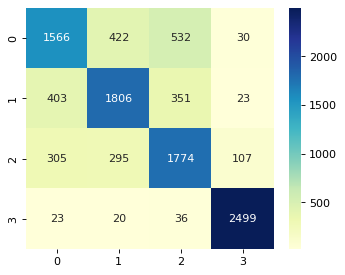

In [71]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# RandomForestClassifier

In [72]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_for_model, y_train)
rf_model

RandomForestClassifier()

In [73]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = rf_model.predict(X_test_features)

In [74]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.11145996860282574
MSE: 0.1534536891679749
RMSE: 0.39173165453914355
R2 Square 0.877850595847285
Accuracy 0.9093406593406593
__________________________________


In [75]:
results_df_2 = pd.DataFrame(data=[["RandomForestClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.288952,0.432398,0.657570,0.655810,0.781005
1,SVC,0.301707,0.463206,0.680593,0.631287,0.777374
2,RBF SVC,0.368132,0.587520,0.766498,0.532333,0.735184
3,DecisionTreeClassifier,0.191425,0.282869,0.531854,0.774836,0.854003
4,LogisticRegression,0.376472,0.600962,0.775217,0.521634,0.728414
5,SGDClassifier,0.350667,0.568878,0.754240,0.547172,0.753140
6,GradientBoostingClassifier,0.314757,0.490385,0.700275,0.609653,0.769918
7,LGBMClassifier,0.208399,0.309458,0.556290,0.753671,0.841739
8,XGBClassifier,0.346644,0.550530,0.741977,0.561777,0.750098
9,RandomForestClassifier,0.111460,0.153454,0.391732,0.877851,0.909341


In [76]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      2550
           1       0.87      0.88      0.87      2583
           2       0.86      0.83      0.85      2481
           3       0.98      1.00      0.99      2578

    accuracy                           0.91     10192
   macro avg       0.91      0.91      0.91     10192
weighted avg       0.91      0.91      0.91     10192



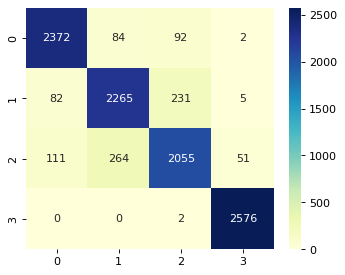

In [77]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# GaussianNB

In [78]:
from sklearn.naive_bayes import GaussianNB


GB_model = GaussianNB()
GB_model = GB_model.fit(X_for_model, y_train)
GB_model

GaussianNB()

In [79]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = GB_model.predict(X_test_features)

In [80]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.6019427001569859
MSE: 0.9021781789638933
RMSE: 0.9498306054049287
R2 Square 0.2818645964295301
Accuracy 0.5188383045525903
__________________________________


In [81]:
results_df_2 = pd.DataFrame(data=[["GaussianNB", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.288952,0.432398,0.657570,0.655810,0.781005
1,SVC,0.301707,0.463206,0.680593,0.631287,0.777374
2,RBF SVC,0.368132,0.587520,0.766498,0.532333,0.735184
3,DecisionTreeClassifier,0.191425,0.282869,0.531854,0.774836,0.854003
4,LogisticRegression,0.376472,0.600962,0.775217,0.521634,0.728414
5,SGDClassifier,0.350667,0.568878,0.754240,0.547172,0.753140
6,GradientBoostingClassifier,0.314757,0.490385,0.700275,0.609653,0.769918
7,LGBMClassifier,0.208399,0.309458,0.556290,0.753671,0.841739
8,XGBClassifier,0.346644,0.550530,0.741977,0.561777,0.750098
9,RandomForestClassifier,0.111460,0.153454,0.391732,0.877851,0.909341


In [82]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.70      0.09      0.16      2550
           1       0.38      0.90      0.54      2583
           2       0.64      0.19      0.29      2481
           3       0.74      0.88      0.80      2578

    accuracy                           0.52     10192
   macro avg       0.62      0.51      0.45     10192
weighted avg       0.62      0.52      0.45     10192



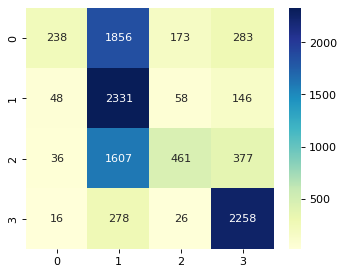

In [83]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

In [84]:
modeller = [rf_model,GB_model,XGBC_model,LGBM_model,GBC_model,SGD_model,lr_model,cart_model,svc_model,svm_model,knn_model]

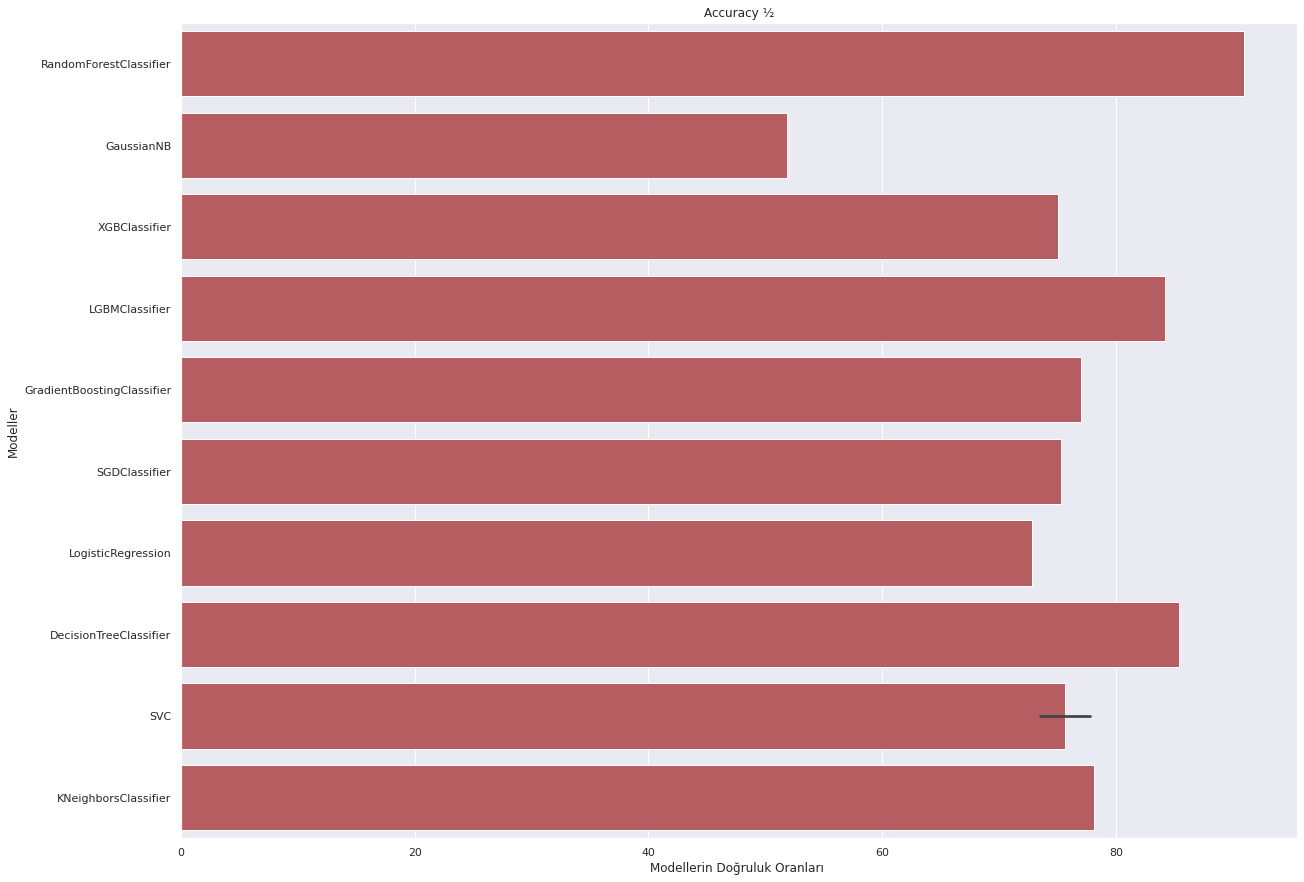

In [85]:
sonuc = []
from sklearn.metrics import accuracy_score

sonuclar = pd.DataFrame(columns= ["Modeller","Accuracy"])

for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test_features)
    dogruluk = accuracy_score(y_test, y_pred)    
    sonuc = pd.DataFrame([[isimler, dogruluk*100]], columns= ["Modeller","Accuracy"])
    sonuclar = sonuclar.append(sonuc)
    
sns.set(rc={'figure.figsize':(20,15)})
sns.barplot(x= 'Accuracy', y = 'Modeller', data=sonuclar, color="r")
plt.xlabel('Modellerin Doğruluk Oranları ')
plt.title('Accuracy ½'); 

In [86]:
results_df


,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.288952,0.432398,0.657570,0.655810,0.781005
1,SVC,0.301707,0.463206,0.680593,0.631287,0.777374
2,RBF SVC,0.368132,0.587520,0.766498,0.532333,0.735184
3,DecisionTreeClassifier,0.191425,0.282869,0.531854,0.774836,0.854003
4,LogisticRegression,0.376472,0.600962,0.775217,0.521634,0.728414
5,SGDClassifier,0.350667,0.568878,0.754240,0.547172,0.753140
6,GradientBoostingClassifier,0.314757,0.490385,0.700275,0.609653,0.769918
7,LGBMClassifier,0.208399,0.309458,0.556290,0.753671,0.841739
8,XGBClassifier,0.346644,0.550530,0.741977,0.561777,0.750098
9,RandomForestClassifier,0.111460,0.153454,0.391732,0.877851,0.909341


In [89]:
from google.colab import files

results_df.to_csv('output_vgg19.csv', encoding = 'utf-8-sig') 
files.download('output_vgg19.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>